# Wake steering

This example demonstrates how to optimize the yaw angles of wind turbine rotors, such that the wakes are steered away from downwind turbines.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import foxes
import foxes.variables as FV
from iwopy.interfaces.pymoo import Optimizer_pymoo
from foxes_opt.problems import OptFarmVars
from foxes_opt.objectives import MaxFarmPower

Let's initialize the *foxes* engine, which will be used for all calculations:

In [2]:
engine = foxes.Engine.new(
    "process",
    chunk_size_states=500,
    chunk_size_points=5000,
    verbosity=0,
)
engine.initialize()

In this example we are looking at a small 3 x 3 regualar wind farm with `NREL5MW` turbines:

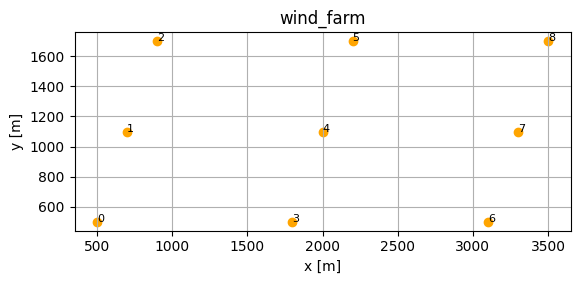

In [3]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm,
    xy_base=np.array([500.0, 500.0]),
    step_vectors=np.array([[1300.0, 0], [200, 600.0]]),
    steps=(3, 3),
    turbine_models=["opt_yawm", "yawm2yaw", "NREL5MW"],
    verbosity=0,
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure()
plt.show()
plt.close(ax.get_figure())

Notice how the name of the optimization model `opt_yawm`, which will be defined shortly, appears in the list of turbine models. The idea is as follows:

- First, the optimizer sets the `FV.YAWM` variable, representing _yaw misalignment_ in degrees, i.e., a delta yaw value from greedy conditions
- Then, the model `yawm2yaw` translates this into the absolute yaw value, i.e., the absolute turbine axis orientation, expressed in degrees
- This setting is then used for thrust and power calculations, by the turbine type model `NREL5MW`.

We are considering sinlge-state uniform inflow conditions:

In [4]:
states = foxes.input.states.SingleStateStates(ws=9, wd=270, ti=0.06, rho=1.225)

The algorithm is defined next, including a TI wake model and the `TurbOPark` wake model with `vector` wind superposition. Also notice the wake deflection choice `Jimenez`, which realizes the wake bending for yawed conditions:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="grid25",
    wake_models=["IECTI2019k_quadratic_ambka04", "TurbOPark_vector_ambka004"],
    wake_frame="rotor_wd",
    wake_deflection="Jimenez",
    verbosity=0,
)

The optimization problem is power maximization by finding the optimal value of the variable `FV.YAWM` for each turbine:

In [6]:
problem = OptFarmVars("opt_yawm", algo)
problem.add_var(FV.YAWM, float, 0.0, -30.0, 30.0, level="turbine")
problem.add_objective(MaxFarmPower(problem))
problem.initialize()

Problem 'opt_yawm': Optimization variable list

        name   var   type  index    level  state  turbine  sel_turbine  init  \
0  YAWM_0000  YAWM  float      0  turbine     -1        0            0   0.0   
1  YAWM_0001  YAWM  float      1  turbine     -1        1            1   0.0   
2  YAWM_0002  YAWM  float      2  turbine     -1        2            2   0.0   
3  YAWM_0003  YAWM  float      3  turbine     -1        3            3   0.0   
4  YAWM_0004  YAWM  float      4  turbine     -1        4            4   0.0   
5  YAWM_0005  YAWM  float      5  turbine     -1        5            5   0.0   
6  YAWM_0006  YAWM  float      6  turbine     -1        6            6   0.0   
7  YAWM_0007  YAWM  float      7  turbine     -1        7            7   0.0   
8  YAWM_0008  YAWM  float      8  turbine     -1        8            8   0.0   

    min   max pre_rotor model_key  
0 -30.0  30.0     False  opt_yawm  
1 -30.0  30.0     False  opt_yawm  
2 -30.0  30.0     False  opt_yawm  
3 -30.0

Next, we setup the solver:

In [7]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(vectorize=True),
    algo_pars=dict(type="GA", pop_size=100, seed=42),
    setup_pars=dict(),
    term_pars=("n_gen", 100),
)
solver.initialize()
solver.print_info()

Loading pymoo


pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: GA (GA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: GA
  pop_size: 100
  seed: 42

Termination:
------------
  n_gen: 100



Now everything is setup, and we can solve the problem:

In [8]:
results = solver.solve()
solver.finalize(results)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 | -2.878740E-01 | -3.186811E-01
     2 |      200 | -3.026773E-01 | -3.295366E-01


     3 |      300 | -3.120158E-01 | -3.318803E-01
     4 |      400 | -3.186522E-01 | -3.377062E-01


     5 |      500 | -3.241173E-01 | -3.378528E-01
     6 |      600 | -3.285777E-01 | -3.405224E-01


     7 |      700 | -3.333014E-01 | -3.436903E-01
     8 |      800 | -3.365679E-01 | -3.465198E-01
     9 |      900 | -3.385969E-01 | -3.474547E-01


    10 |     1000 | -3.406454E-01 | -3.474547E-01
    11 |     1100 | -3.424235E-01 | -3.484300E-01
    12 |     1200 | -3.441875E-01 | -3.484300E-01


    13 |     1300 | -3.457689E-01 | -3.484300E-01
    14 |     1400 | -3.469715E-01 | -3.490283E-01
    15 |     1500 | -3.476289E-01 | -3.493630E-01


    16 |     1600 | -3.479459E-01 | -3.495039E-01
    17 |     1700 | -3.482261E-01 | -3.495039E-01
    18 |     1800 | -3.484397E-01 | -3.495061E-01


    19 |     1900 | -3.486801E-01 | -3.495582E-01
    20 |     2000 | -3.489580E-01 | -3.495645E-01
    21 |     2100 | -3.492103E-01 | -3.496101E-01


    22 |     2200 | -3.494371E-01 | -3.497790E-01
    23 |     2300 | -3.495382E-01 | -3.497790E-01
    24 |     2400 | -3.495988E-01 | -3.498233E-01


    25 |     2500 | -3.496523E-01 | -3.498402E-01
    26 |     2600 | -3.497119E-01 | -3.499171E-01
    27 |     2700 | -3.497590E-01 | -3.499418E-01


    28 |     2800 | -3.497939E-01 | -3.499418E-01
    29 |     2900 | -3.498210E-01 | -3.499418E-01


    30 |     3000 | -3.498482E-01 | -3.499418E-01
    31 |     3100 | -3.498770E-01 | -3.499530E-01


    32 |     3200 | -3.499022E-01 | -3.499591E-01
    33 |     3300 | -3.499241E-01 | -3.499591E-01
    34 |     3400 | -3.499374E-01 | -3.499708E-01


    35 |     3500 | -3.499449E-01 | -3.499722E-01
    36 |     3600 | -3.499503E-01 | -3.499722E-01
    37 |     3700 | -3.499547E-01 | -3.499722E-01


    38 |     3800 | -3.499593E-01 | -3.499766E-01
    39 |     3900 | -3.499632E-01 | -3.499810E-01


    40 |     4000 | -3.499675E-01 | -3.499870E-01
    41 |     4100 | -3.499719E-01 | -3.499980E-01
    42 |     4200 | -3.499768E-01 | -3.500047E-01


    43 |     4300 | -3.499801E-01 | -3.500047E-01
    44 |     4400 | -3.499854E-01 | -3.500088E-01
    45 |     4500 | -3.499905E-01 | -3.500092E-01


    46 |     4600 | -3.499945E-01 | -3.500135E-01
    47 |     4700 | -3.499981E-01 | -3.500136E-01
    48 |     4800 | -3.500023E-01 | -3.500136E-01


    49 |     4900 | -3.500052E-01 | -3.500136E-01
    50 |     5000 | -3.500077E-01 | -3.500156E-01
    51 |     5100 | -3.500093E-01 | -3.500156E-01


    52 |     5200 | -3.500104E-01 | -3.500156E-01
    53 |     5300 | -3.500116E-01 | -3.500175E-01
    54 |     5400 | -3.500132E-01 | -3.500177E-01


    55 |     5500 | -3.500142E-01 | -3.500177E-01
    56 |     5600 | -3.500149E-01 | -3.500177E-01
    57 |     5700 | -3.500157E-01 | -3.500178E-01


    58 |     5800 | -3.500163E-01 | -3.500179E-01
    59 |     5900 | -3.500170E-01 | -3.500182E-01
    60 |     6000 | -3.500175E-01 | -3.500182E-01


    61 |     6100 | -3.500177E-01 | -3.500182E-01
    62 |     6200 | -3.500178E-01 | -3.500188E-01
    63 |     6300 | -3.500179E-01 | -3.500188E-01


    64 |     6400 | -3.500180E-01 | -3.500188E-01
    65 |     6500 | -3.500182E-01 | -3.500188E-01
    66 |     6600 | -3.500183E-01 | -3.500188E-01


    67 |     6700 | -3.500184E-01 | -3.500190E-01
    68 |     6800 | -3.500185E-01 | -3.500191E-01
    69 |     6900 | -3.500186E-01 | -3.500191E-01


    70 |     7000 | -3.500187E-01 | -3.500192E-01
    71 |     7100 | -3.500188E-01 | -3.500193E-01
    72 |     7200 | -3.500189E-01 | -3.500193E-01


    73 |     7300 | -3.500190E-01 | -3.500193E-01
    74 |     7400 | -3.500191E-01 | -3.500194E-01


    75 |     7500 | -3.500192E-01 | -3.500194E-01
    76 |     7600 | -3.500193E-01 | -3.500194E-01


    77 |     7700 | -3.500193E-01 | -3.500194E-01
    78 |     7800 | -3.500193E-01 | -3.500194E-01


    79 |     7900 | -3.500193E-01 | -3.500194E-01
    80 |     8000 | -3.500193E-01 | -3.500195E-01


    81 |     8100 | -3.500194E-01 | -3.500195E-01
    82 |     8200 | -3.500194E-01 | -3.500196E-01


    83 |     8300 | -3.500194E-01 | -3.500198E-01
    84 |     8400 | -3.500194E-01 | -3.500198E-01
    85 |     8500 | -3.500194E-01 | -3.500198E-01


    86 |     8600 | -3.500195E-01 | -3.500198E-01
    87 |     8700 | -3.500195E-01 | -3.500198E-01
    88 |     8800 | -3.500196E-01 | -3.500198E-01


    89 |     8900 | -3.500196E-01 | -3.500198E-01
    90 |     9000 | -3.500196E-01 | -3.500198E-01


    91 |     9100 | -3.500196E-01 | -3.500198E-01
    92 |     9200 | -3.500197E-01 | -3.500198E-01
    93 |     9300 | -3.500197E-01 | -3.500198E-01


    94 |     9400 | -3.500198E-01 | -3.500198E-01
    95 |     9500 | -3.500198E-01 | -3.500198E-01
    96 |     9600 | -3.500198E-01 | -3.500198E-01


    97 |     9700 | -3.500198E-01 | -3.500198E-01
    98 |     9800 | -3.500198E-01 | -3.500198E-01
    99 |     9900 | -3.500198E-01 | -3.500199E-01


   100 |    10000 | -3.500198E-01 | -3.500199E-01


Optimizer_pymoo: Optimization run finished
  Success: True
  Best maximize_power = 15750.89386869412


In [9]:
print()
print(results)

fr = results.problem_results.to_dataframe()
fr[[FV.X, FV.Y, FV.AMB_WD, FV.YAWM, FV.TI, FV.REWS, FV.P]]


Results problem 'opt_yawm':
----------------------------
  Float variables:
    0: YAWM_0000 = 2.740050e+01
    1: YAWM_0001 = -2.394155e+01
    2: YAWM_0002 = -2.392788e+01
    3: YAWM_0003 = 1.480058e+01
    4: YAWM_0004 = -1.516539e+01
    5: YAWM_0005 = -1.516312e+01
    6: YAWM_0006 = -1.422687e+00
    7: YAWM_0007 = 1.428005e+00
    8: YAWM_0008 = 1.415896e+00
----------------------------
  Objectives:
    0: maximize_power = 1.575089e+04
----------------------------
  Success: True
----------------------------



X       Y  AMB_WD       YAWM        TI      REWS  \
state turbine                                                          
0     0         500.0   500.0   270.0  27.400495  0.060000  9.000000   
      1         700.0  1100.0   270.0 -23.941554  0.060000  8.225639   
      2         900.0  1700.0   270.0 -23.927882  0.060000  8.226510   
      3        1800.0   500.0   270.0  14.800577  0.072561  7.887085   
      4        2000.0  1100.0   270.0 -15.165388  0.075521  7.841165   
      5        2200.0  1700.0   270.0 -15.163123  0.075537  7.840689   
      6        3100.0   500.0   270.0  -1.422687  0.095375  8.202245   
      7        3300.0  1100.0   270.0   1.428005  0.095483  8.141355   
      8        3500.0  1700.0   270.0   1.415896  0.095494  8.140607   

                         P  
state turbine               
0     0        2035.173756  
      1        1639.550917  
      2        1640.333081  
      3        1608.812882  
      4        1577.776360  
      5        1577.534974  
      6        1921.093780  
      7        1875.578697  
      8        1875.039421

Finally, we can visualize the result by looking at the flow field:

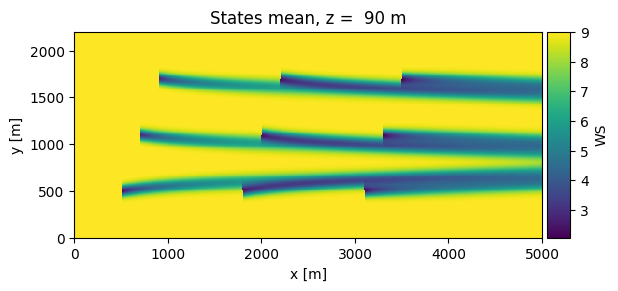

In [10]:
o = foxes.output.FlowPlots2D(algo, results.problem_results)
fig = o.get_mean_fig_xy("WS", resolution=10, xmax=5000)
plt.show()

Clearly the turbines are trying to avoid hitting downwind turbines with their wakes.

Finally, let's shutdown the *foxes* engine:

In [11]:
engine.finalize()